In [1]:
import pandas as pd 
import os 
import cantera as ct 
import sys
from subprocess import run
import re
import graphviz
from IPython.display import display

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from  props_0D import *

# --- Paths and case info ---
QSSA_path = "../../figs/QSSA/data/"
RCCE_path = "../../figs/RCCE/data/"
data_dir  = "../../data"
# case_name = "case_NH3_0D"
case_name = "case_NH3_counterflow"



# initialize gas path 

props = props_list[0]
last_spec = 'AR'
gas = ct.Solution(props['mech_file'])
specs = gas.species()[:]
N2_ind = gas.species_index(last_spec)
gas = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                species=specs[:N2_ind] + specs[N2_ind + 1:] + [specs[N2_ind]],
                reactions=gas.reactions())
main_species_names  = gas.species_names


<ipython-input-1-8b265789cf41>:28: DeprecationWarning: XML_Node::build: 
The CTI and XML input file formats are deprecated and will be removed in
Cantera 3.0. Use 'cti2yaml.py' or 'ctml2yaml.py' to convert CTI or XML input
files to the YAML format. See https://cantera.org/tutorials/legacy2yaml.html
for more information.
  gas = ct.Solution(props['mech_file'])


In [2]:
import os
import re
from subprocess import run
import graphviz
import cantera as ct
from IPython.display import display

def create_reaction_path_diagram(gas, fig_dir, element, cantera_row, pred_cantera_row):
    # Prepare species compositions from cantera row
    all_species_names = gas.species_names
    all_species_values = [cantera_row[name] for name in all_species_names]
    all_fractions = dict(zip(all_species_names, all_species_values))
    species_composition = ", ".join([f"{sp}:{mf}" for sp, mf in all_fractions.items()])
    gas.TPX = cantera_row['T'], cantera_row['P'], species_composition

    # Create the reaction path diagram
    diagram = ct.ReactionPathDiagram(gas, element)
    diagram.title = f""
    diagram.show_details = False  # 禁用Scale等细节
    # If edges disappear, try lowering or removing label_threshold:
    diagram.label_threshold = 0.0001

    # Set up output paths
    output_dir = fig_dir
    dot_file = f"{element}_rxnpath.dot"
    modified_dot_file = f"{element}_rxnpath_modified.dot"
    img_file = f"{element}_rxnpath.pdf"

    os.makedirs(output_dir, exist_ok=True)
    dot_path = os.path.join(output_dir, dot_file)
    img_path = os.path.join(output_dir, img_file)

    # 1) Write the DOT file from Cantera
    diagram.write_dot(dot_path)
    print(f"Wrote graphviz input file to '{dot_path}'.")

    # 2) Modify the DOT file (orthogonal edges, solid lines, invisible edge-label font color, node styling)
    modify_dot_file(dot_path, cantera_row, pred_cantera_row, all_species_names)
    dot_path = os.path.join(output_dir, modified_dot_file)

    # 3) Display the modified DOT graph inline
    src = graphviz.Source.from_file(dot_path)
    display(src)

    # 4) Generate a PDF using Graphviz.
    #    If 'dot' fails due to `splines=ortho`, try "neato" or "dot -Kneato"
    run(["dot", "-Tpdf", dot_path, "-o", img_path, "-Gdpi=200"], check=True)
    print(f"Wrote graphviz output file to '{img_path}'.")


def modify_dot_file(dot_file_path, cantera_row, pred_cantera_row, all_species_names):
    with open(dot_file_path, "r") as file:
        dot_content = file.read()
        
    brace_index = dot_content.find("{")
    if brace_index != -1:
        # insertion = (
        #     "\n  graph [splines=ortho];\n"
        #     "  edge [style=solid, labelfontcolor=transparent, color=transparent, fontcolor=transparent, label=\"\"];\n"  # 添加空label
        # )
        insertion = (
        "\n  graph [splines=ortho];\n"
        "  edge [style=solid, labelfontcolor=transparent, color=transparent, "
        "fontcolor=transparent, label=\"\", fontsize=0, penwidth=2];\n"  # 字体设为0大小
    )
        dot_content = dot_content[:brace_index + 1] + insertion + dot_content[brace_index + 1:]



    # --------------------------------------------------------------------
    # Step 1: (Optional) We no longer strip out the edge 'label' attributes,
    #         since we want penwidth to remain and we are making them invisible
    #         by setting labelfontcolor=white. 
    #
    #         If you do want to remove them entirely, uncomment a regex 
    #         that removes (x|tail|head)?label="...".
    # --------------------------------------------------------------------

    # Debug: Print node labels found in the DOT file
    species_pattern = re.compile(r'label="([A-Za-z0-9()]+)"')
    found_species = re.findall(species_pattern, dot_content)
    print("Species found in the .dot file:")
    for sp in found_species:
        print(f"  {sp}")

    # Normalize species names for case-insensitive matching
    all_species_names_normalized = [s.lower().strip() for s in all_species_names]
    print("Normalized species in all_species_names:", all_species_names_normalized)

    # --------------------------------------------------------------------
    # Step 2: Modify node labels & color
    # --------------------------------------------------------------------
    def compute_error(species_name):
        cantera_value = cantera_row.get(species_name, 0)
        pred_value = pred_cantera_row.get(species_name, 0)
        error = 0
        if cantera_value != 0:
            error = (pred_value - cantera_value) / cantera_value
        print(f"Species: {species_name}, Cantera: {cantera_value}, Pred: {pred_value}, Error: {error}")
        return error

    def error_to_color(error):
        # Map error from green (0) to red (1)
        abs_error_percent = min(abs(error) * 100, 100)
        norm_error = abs_error_percent / 100
        red = int(255 * norm_error)
        green = int(255 * (1 - norm_error))
        # Lighten the color
        lightening_factor = 100
        red = min(red + lightening_factor, 255)
        green = min(green + lightening_factor, 255)
        return f"#{red:02x}{green:02x}00"

    def modify_label_and_color(match):
        species_label = match.group(1).strip()
        if species_label.lower() in all_species_names_normalized:
            error = compute_error(species_label)
            if abs(error) < 0.001:
                err_str = "set"
            else:
                err_str = f"{error * 100:.2f}%"
            color = error_to_color(abs(error))
            new_label = f'{species_label} {err_str}'
            return f'label="{new_label}", style=filled, fillcolor="{color}", shape="box"'
        else:
            return match.group(0)



    modified_dot_content = re.sub(species_pattern, modify_label_and_color, dot_content)

    # Step 3: 仅移除边的label属性（保留其他属性结构）
    edge_label_pattern = re.compile(
        r'(edge\s*$$)(.*?)(\blabel\s*=\s*"[^"]*"\s*,?)(.*?)($$)',
        re.DOTALL
    )
    modified_dot_content = re.sub(edge_label_pattern, r'\1\2\4\5', modified_dot_content)
    # --------------------------------------------------------------------
    # Step 3: Save the modified file
    # --------------------------------------------------------------------
    output_dot_file = dot_file_path.replace(".dot", "_modified.dot")
    with open(output_dot_file, "w") as f:
        f.write(modified_dot_content)

    print(f"Modified dot file saved as {output_dot_file}")


Wrote graphviz input file to 'figs/N_rxnpath.dot'.
Species found in the .dot file:
  NO
  NH2
  NH
  N
  NNH
  HNO
  NO2
  HONO
  N2O
  N2
Normalized species in all_species_names: ['no', 'nh3', 'h2', 'o2', 'h', 'o', 'oh', 'ho2', 'h2o', 'h2o2', 'nh2', 'nh', 'n', 'nnh', 'nh2oh', 'h2no', 'hnoh', 'hno', 'hon', 'no2', 'hono', 'hno2', 'no3', 'hono2', 'n2o', 'n2h4', 'n2h3', 'n2h2', 'h2nn', 'n2', 'ar']
Species: NO, Cantera: 0.0009892964989948, Pred: 0.001026852972916, Error: 0.03796280888425262
Species: NH2, Cantera: 5.252697481076132e-09, Pred: 5.252697481076132e-09, Error: 0.0
Species: NH, Cantera: 1.0283981688122661e-08, Pred: 1.0283981688122661e-08, Error: 0.0
Species: N, Cantera: 3.6990301302251216e-08, Pred: 3.6990301302251216e-08, Error: 0.0
Species: NNH, Cantera: 9.10097720996374e-09, Pred: 9.10097720996374e-09, Error: 0.0
Species: HNO, Cantera: 7.869423929327782e-08, Pred: 7.869423929327782e-08, Error: 0.0
Species: NO2, Cantera: 3.399817017453768e-07, Pred: 3.399817017453768e-07, Erro

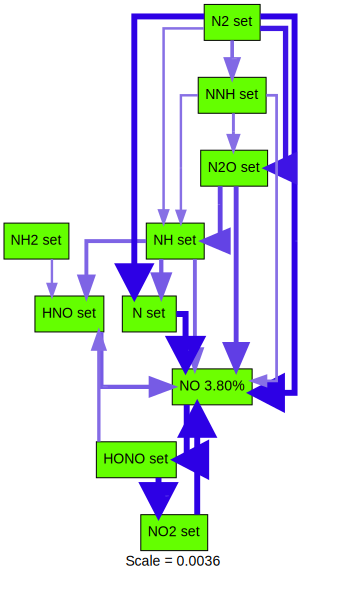

Wrote graphviz output file to 'figs/N_rxnpath.pdf'.


In [12]:
# ---------------------
# Example usage (commented out):
# ---------------------
target_case = "N_CF_3"
fig_dir = 'figs/'

original_data_path = os.path.join(data_dir, case_name, target_case) + ".csv"
df = pd.read_csv(original_data_path)
recon_case_path = os.path.join(QSSA_path, case_name, target_case, "predicted_X.csv")
df_pred = pd.read_csv(recon_case_path)

max_hrr_value = 0
# Find the maximum HRR row
for index, row in df.iterrows():
    if row['Qdot'] > max_hrr_value:
        max_hrr_value = row['Qdot']
        max_hrr_index = index

max_hrr_row = df.loc[max_hrr_index]
pred_hrr_row = df_pred.loc[max_hrr_index]

elements = ['N']  # or ['O','H','N'] etc.
for element in elements:
    create_reaction_path_diagram(gas, fig_dir, element, max_hrr_row, pred_hrr_row)

max_hrr_index= 99
Wrote graphviz input file to 'figs/O_rxnpath.dot'.
Species found in the .dot file:
  O2
  O
  OH
  HO2
  H2O
  H2O2
Normalized species in all_species_names: ['no', 'nh3', 'h2', 'o2', 'h', 'o', 'oh', 'ho2', 'h2o', 'h2o2', 'nh2', 'nh', 'n', 'nnh', 'nh2oh', 'h2no', 'hnoh', 'hno', 'hon', 'no2', 'hono', 'hno2', 'no3', 'hono2', 'n2o', 'n2h4', 'n2h3', 'n2h2', 'h2nn', 'n2', 'ar']
Species: O2, Cantera: 0.0080251373409858, Pred: 0.0080251373409858, Error: 0.0
Species: O, Cantera: 0.0005361241398641, Pred: 0.0005361241398641, Error: 0.0
Species: OH, Cantera: 0.0072331922024999, Pred: 0.0072331922024999, Error: 0.0
Species: HO2, Cantera: 2.964787696672729e-06, Pred: 2.964787696672729e-06, Error: 0.0
Species: H2O, Cantera: 0.2925415256716923, Pred: 0.2925415256716923, Error: 0.0
Species: H2O2, Cantera: 5.119877532949614e-07, Pred: 5.119877532949614e-07, Error: 0.0
Modified dot file saved as figs/O_rxnpath_modified.dot


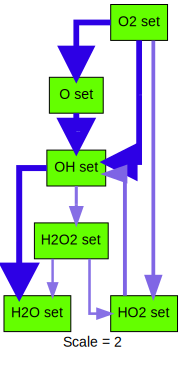

Wrote graphviz output file to 'figs/O_rxnpath.pdf'.


In [11]:
# ---------------------
# Example usage (commented out):
# ---------------------
target_case = "N_CF_3"
fig_dir = 'figs/'

original_data_path = os.path.join(data_dir, case_name, target_case) + ".csv"
df = pd.read_csv(original_data_path)
recon_case_path = os.path.join(QSSA_path, case_name, target_case, "predicted_X.csv")
df_pred = pd.read_csv(recon_case_path)

max_hrr_value = 0
# Find the maximum HRR row
for index, row in df.iterrows():
    if row['Qdot'] > max_hrr_value:
        max_hrr_value = row['Qdot']
        max_hrr_index = index

print("max_hrr_index=", max_hrr_index)
max_hrr_row = df.loc[max_hrr_index]
pred_hrr_row = df_pred.loc[max_hrr_index]

elements = ['O']  # or ['O','H','N'] etc.
for element in elements:
    create_reaction_path_diagram(gas, fig_dir, element, max_hrr_row, pred_hrr_row)